In [1]:
from rdkit.Chem import Draw
from rdkit import Chem

In [2]:
import os
os.chdir('../programming_scripts/.')
print(os.getcwd())

from MS2LDA_core import run_lda
from MS2LDA_core import predict_with_lda

from MS2LDA_core import load_mgf
from MS2LDA_core import clean_spectra

from utils import motifs2spectra
from spec2vec import Spec2Vec

import heapq
import numpy as np

from matchms import Spectrum, Fragments
from matchms import calculate_scores

C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubstructureIdentification\scripts\programming_scripts


In [3]:
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-COLLECTIONS-PESTICIDES-POSITIVE.mgf"
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE.mgf"
#spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-SCIEX-LIBRARY.mgf"
# 12 motifs n. 11 interessant; 
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\MEDUSA\notebooks\MS2LDA\PDE5_standards_annotated_pos_unique.mgf"
spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\_removeMeAfterCheck\Project_TEATRO\processed_data\_processed_data1\EFSA_Tab_B_extension_massbank_positive.mgf"

In [4]:
lda_model, corpus, id2word = run_lda(spectra_path=spectra_path, num_motifs=102, iterations=100)

In [5]:
motif_spectra = motifs2spectra(lda_model)

In [8]:
mn = 22

[ 43.03  70.04  70.05 125.02 131.   131.97 169.05 181.  ]
TOP 3 frags:  [(70.04, 1.0), (131.97, 0.9023596482593911), (70.05, 0.658443769490559)]
TOP 3 losses:  [(253.09, 0.3885066562532037), (178.07, 0.3232790257998997), (226.08, 0.14927000125300363)]


(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum'}, xlabel='m/z', ylabel='Intensity'>)

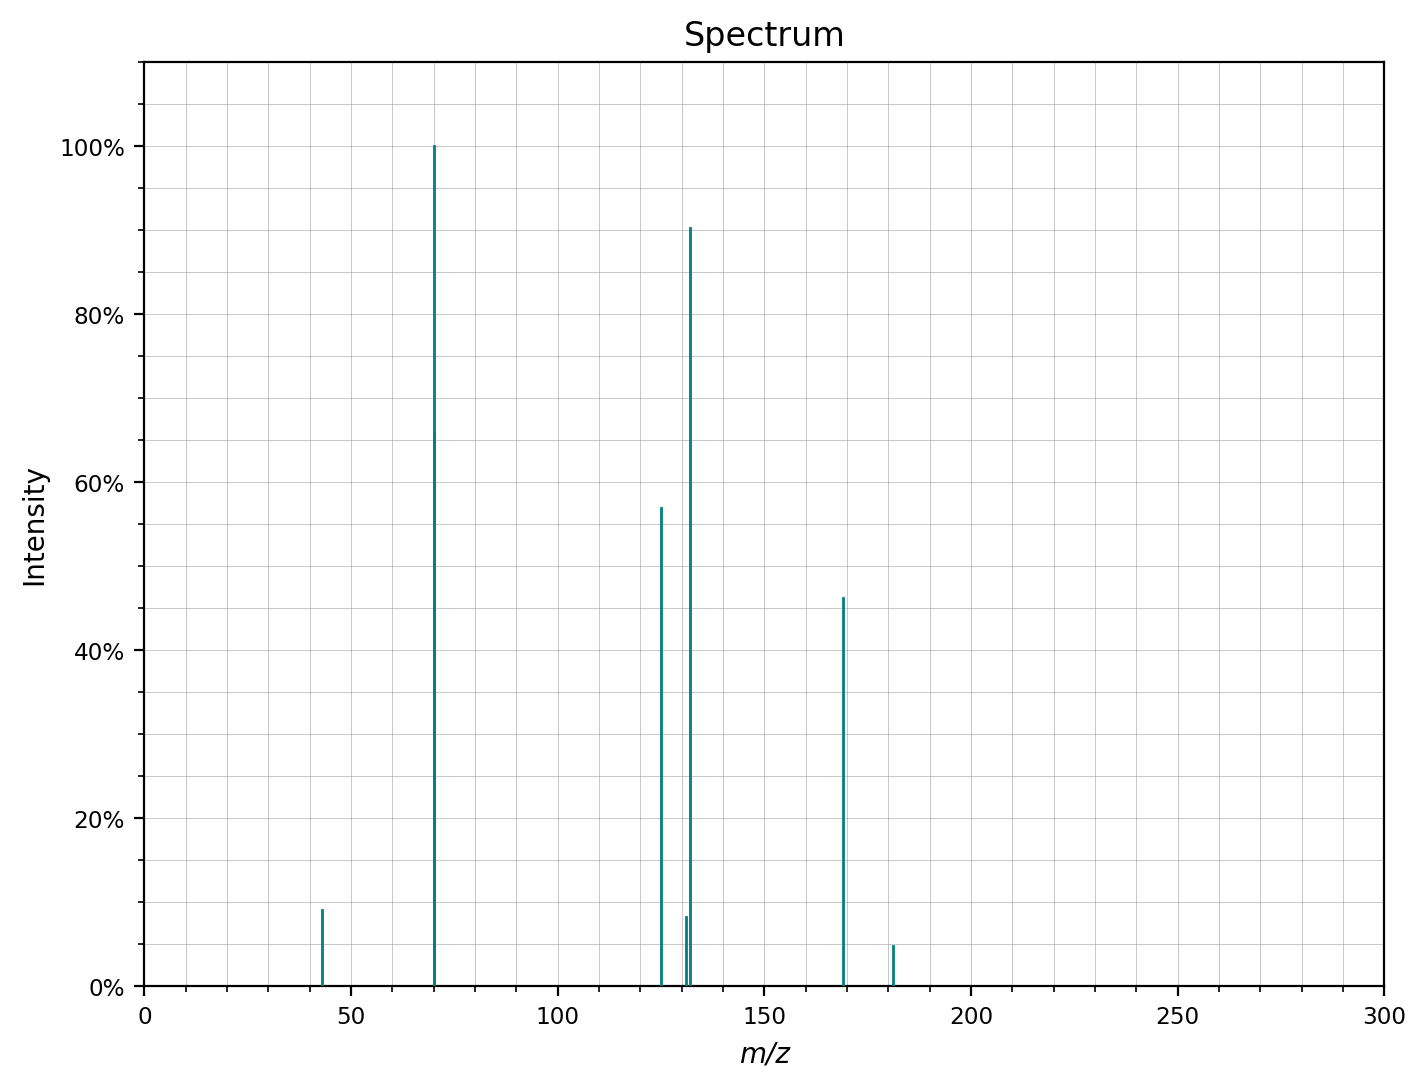

In [9]:
print(motif_spectra[mn].peaks.mz)
print("TOP 3 frags: ", heapq.nlargest(3, list(zip(motif_spectra[mn].peaks.mz, motif_spectra[mn].peaks.intensities)), key = lambda x: x[1]))
print("TOP 3 losses: ", heapq.nlargest(3, list(zip(motif_spectra[mn].losses.mz, motif_spectra[mn].losses.intensities)), key = lambda x: x[1]))
motif_spectra[mn].plot()

In [7]:
#smiles_per_motifs, predicted_motifs, predicted_motifs_distribution, spectra_per_motifs = predict_with_lda(lda_model, spectra_path, id2word)

### Motif analysis

In [8]:
from Spec2Vec_annotation import load_model_and_data
from Spec2Vec_annotation import calc_similarity
from Spec2Vec_annotation import retrieve_top_hits

In [9]:
s2v_model, embeddings_smiles_DB = load_model_and_data()

In [10]:
smiles = embeddings_smiles_DB.smiles.to_numpy()
embeddings_DB = embeddings_smiles_DB.embeddings.to_list()
spectra_DB = embeddings_smiles_DB.spectra.to_list()

In [11]:
s2v_scores = calc_similarity(s2v_model, motif_spectra, embeddings_DB)

In [546]:
mn = 22

In [547]:
# 101 interesting especially for SHAP's 
# 67 also interesting; unexpected but good substructure
## 37 is main example

In [548]:
top_scores, top_smiles, top_spectra = retrieve_top_hits(s2v_scores, mn, smiles, spectra_DB)

In [549]:
top_scores

(0.5451503511065992,
 0.5421428110311056,
 0.5391010723988945,
 0.5358682167610609,
 0.5329074030467177,
 0.5324594107808447,
 0.5246135623849684,
 0.5217910236607026,
 0.5199379300392543,
 0.5187995024294347)

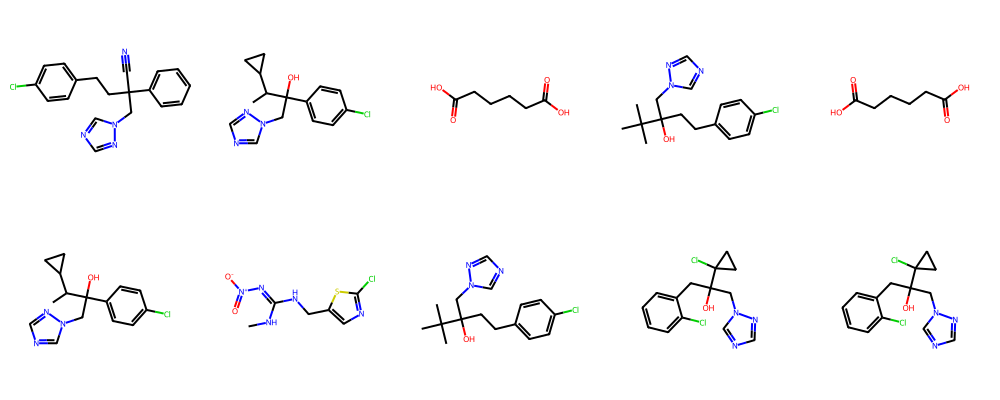

In [550]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in top_smiles], molsPerRow=5)

In [551]:
from rdkit.Chem import rdFMCS

In [552]:
mcs = rdFMCS.FindMCS([Chem.MolFromSmiles(smi) for smi in top_smiles], matchValences=True)

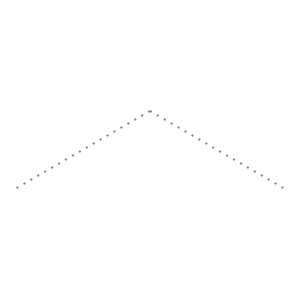

In [553]:
Draw.MolToImage(Chem.MolFromSmarts(mcs.smartsString))

In [554]:
from FP_annotation import annotate_motifs
from Substructure_retrieval import retrieve_substructures

In [555]:
fps_motifs = annotate_motifs([top_smiles], fp_type="adaptive", threshold=0.7) # if another fp then "adaptive" is used you obviously cannot retrieve substructures from it
substructure_matches = retrieve_substructures(fps_motifs, [top_smiles])

[FP]: Executing calc_adaptive


In [556]:
substructure_matches

[['Cl',
  'O',
  'C',
  'Clc1ccccc1',
  'Cn1cncn1',
  'c1ncnn1',
  'CC(C)C',
  'c1ccccc1',
  'CN']]

23 looks good. top 3 peaks
27 i should check out
40 check out
41 really interesting
44 check out
45 check out
48 interesting not so good
50 interesting
52 similar to 23

### Masking

In [557]:
def mask_fragments(spectrum, mask):
    """masks fragments and losses one by one"""

    identifier = spectrum.get("id")
    
    fragments_mz = list(spectrum.peaks.mz)
    fragments_intensities = list(spectrum.peaks.intensities)

    losses_mz = spectrum.losses.mz
    losses_intensities = spectrum.losses.intensities

    masked_spectra = []
    for index in range(len(fragments_mz)):
        masked_fragments_mz = fragments_mz.copy()
        masked_fragments_intensities = fragments_intensities.copy()

        masked_fragments_mz.pop(index)
        masked_fragments_intensities.pop(index)

        retrieved_fragment_intensity = fragments_intensities[index]

        masked_fragments_mz = [mask] + masked_fragments_mz
        masked_fragments_intensities = [retrieved_fragment_intensity] + masked_fragments_intensities

        masked_spectrum = Spectrum(
            mz=np.array(masked_fragments_mz),
            intensities=np.array(masked_fragments_intensities),
            metadata={
                "id": identifier,
                "precursor_mz": max(fragments_mz)
            }
        )

        masked_spectrum.losses = Fragments(
            mz=losses_mz,
            intensities=losses_intensities)

        masked_spectra.append(masked_spectrum)

    return masked_spectra

In [558]:
def mask_losses(spectrum, mask):
    """masks fragments and losses one by one"""

    identifier = spectrum.get("id")
    
    fragments_mz = spectrum.peaks.mz
    fragments_intensities = spectrum.peaks.intensities

    losses_mz = list(spectrum.losses.mz)
    losses_intensities = list(spectrum.losses.intensities)
   
    masked_spectra = []
    for index in range(len(losses_mz)):
        masked_losses_mz = losses_mz.copy()
        masked_losses_intensities = losses_intensities.copy()

        masked_losses_mz.pop(index)
        masked_losses_intensities.pop(index)

        retrieved_loss_intensity = losses_intensities[index]

        masked_losses_mz = [mask] + masked_losses_mz
        masked_losses_intensities = [retrieved_loss_intensity] + masked_losses_intensities

        masked_spectrum = Spectrum(
            mz=fragments_mz,
            intensities=fragments_intensities,
            metadata={
                "id": identifier,
                "precursor_mz": max(fragments_mz)
            }
        )

        masked_spectrum.losses = Fragments(
            mz=np.array(masked_losses_mz),
            intensities=np.array(masked_losses_intensities))

        masked_spectra.append(masked_spectrum)

    return masked_spectra

---

In [559]:
mask_fragment_spectra = mask_fragments(motif_spectra[mn],1.00)

In [560]:
mask_loss_spectra = mask_losses(motif_spectra[mn],1.00)

In [561]:
all_mask_spectra = mask_fragment_spectra + mask_loss_spectra

---

In [562]:
spec2vec_similarity = Spec2Vec(model=s2v_model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=100)

In [563]:
scores = calculate_scores(top_spectra, [motif_spectra[mn]], spec2vec_similarity)
for (reference, query, score) in scores:
    print(f"Cosine score: {score}")

Cosine score: [0.5451503511065992]
Cosine score: [0.5421428110311056]
Cosine score: [0.5391010723988945]
Cosine score: [0.5358682167610609]
Cosine score: [0.5329074030467177]
Cosine score: [0.5324594107808447]
Cosine score: [0.5246135623849684]
Cosine score: [0.5217910236607026]
Cosine score: [0.5199379300392544]
Cosine score: [0.518799502429435]


In [564]:
i = 7
scores = calculate_scores(top_spectra, [all_mask_spectra[i]], spec2vec_similarity)
for (reference, query, score) in scores:
    print(f"Cosine score: {score}")

Cosine score: [0.5497504201037364]
Cosine score: [0.5477315131222242]
Cosine score: [0.5383464676340528]
Cosine score: [0.53564415905791]
Cosine score: [0.5327440114777873]
Cosine score: [0.5374074685597913]
Cosine score: [0.523993880640381]
Cosine score: [0.5220309219349094]
Cosine score: [0.5210258875364]
Cosine score: [0.5195042774818941]


In [565]:
motif_spectra[mn].peaks.mz[i]

181.0

In [566]:
motif_spectra[mn].losses.mz[len(motif_spectra[mn].peaks.mz)-i]

105.06

[ 70.04  83.05  91.05 104.05 125.02 129.07 139.03 151.03 156.08 163.03
 190.04 194.05 216.09 241.08 251.06 268.09 337.12]


(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>)

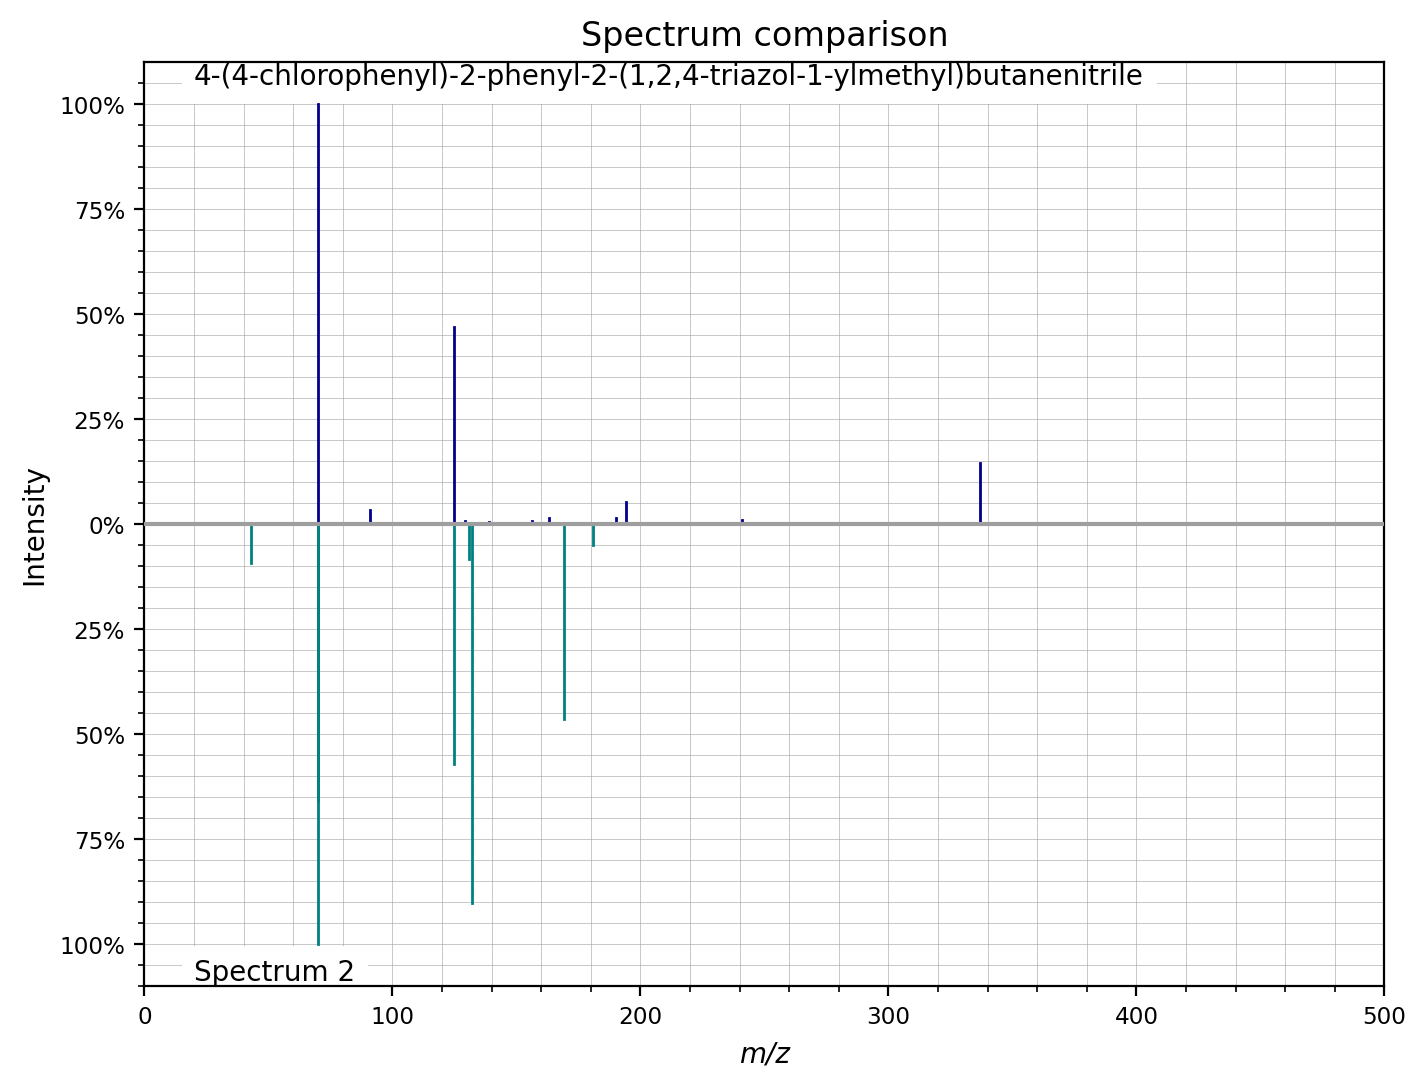

In [567]:
print(top_spectra[0].peaks.mz)
top_spectra[0].plot_against(motif_spectra[mn])

In [568]:
import matplotlib.pyplot as plt

In [569]:
shaps = [list() for i in range(10)]
for i in range(20):
    scores = calculate_scores(top_spectra, [all_mask_spectra[i]], spec2vec_similarity)
    for ii, (reference, query, score) in enumerate(scores):        
        shaps[ii].append(score[0])
        

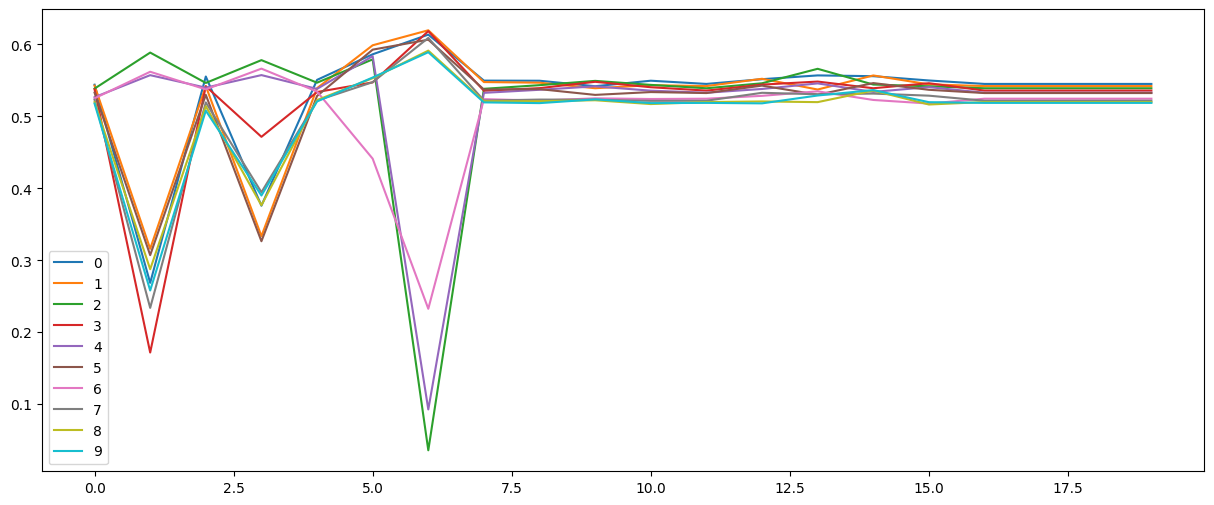

In [570]:
counts = []
plt.figure(figsize=(15,6))
for i, shap in enumerate(shaps):
    plt.plot(shap)
    counts.append(i)
plt.legend(counts)

In [571]:
from scipy.stats import pearsonr, spearmanr

In [572]:
pearsonr(shaps[0], shaps[1])

(0.9771293479341453, 1.4966581356163125e-13)

In [573]:
similarity_matrix = [list() for i in range(10)]
for i in range(10):
    for ii in range(10):
        similarity_matrix[i].append(spearmanr(shaps[i], shaps[ii])[0])

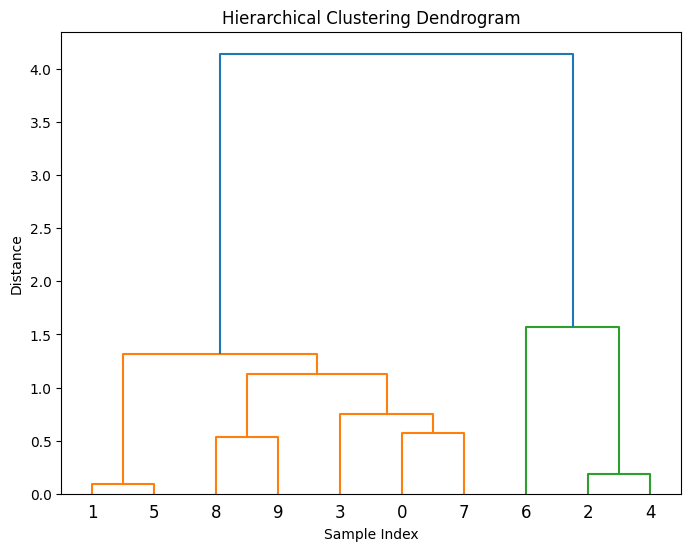

Clusters: [1 1 2 1 2 1 2 1 1 1]


In [574]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Example similarity matrix (replace this with your nxn similarity matrix)
similarity_matrix = np.array(similarity_matrix)

# Perform hierarchical clustering (using complete linkage)
Z = linkage(similarity_matrix, method='complete')

# Plot dendrogram
plt.figure(figsize=(8, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Determine the number of clusters (e.g., by cutting the dendrogram at a specific height)
num_clusters = 2  # Adjust this based on the dendrogram visualization

# Assign data points to clusters based on the number of clusters
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# Print clusters assigned to each data point
print("Clusters:", clusters)


## Spearman works better than pearson it seems !!!

## But you have to set the number of clusters!!! maybe T-SNE or UMAP better for that; both are only for optimization!

if the lowest pearson score is below X than there are probably two clusters.